### Q. 어떤 요소가 대출금 상황 여부에 큰 영향을 줄까?

In [3]:
import pandas as pd
import os

In [4]:
os.chdir(r'C:\Users\hjb38\Documents\데이터 분석 과정\data\credit_data')

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
lb = pd.read_csv('loan_before.csv')

In [6]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

# 1. 문제정의

질문 1 : 어떤 요소가 대출금 상황 여부에 큰 영향을 줄까?

질문 2 : 그 요소들이 상환 여부에 어떤 영향을 줄까?

# 2. 방법론

## 2.1. 분석과정

이 질문에 대한 해답을 얻기 위해 아래와 '해석 가능한 머신러닝(xAI)'를 활용하였다.

### 2.1.1 프로세스

1단계 : feature engineering을 한다.<br>
2단계 : 머신러닝 모델을 만든다.<br>
3단계 : shap value를 통해 어떤 변수가 가장 큰 영향을 주는지 알아본다.<br>
4단계 : 영향을 가장 많이 주는 5개의 변수와 대출금 상환 여부와의 관계를 살펴본다.

## 2.2 Feature Engineering

### 2.2.1  AMT_CREDIT 에서 AMT_ANNUITY 을 나눠, 행당 사람이 몇 개월에 걸쳐 돈을 갚아야 하는지 변수화 한다.
- AMT_CREDIT : 총 대출금액
- AMT_ANNUITY : 매달 갚아야 하는 금액

In [7]:
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,...,-2256,NaN,2.0,15,Kindergarten,NaN,0.665732,NaN,-139.0,1.0
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,...,-4133,NaN,4.0,3,Business Entity Type 3,0.575699,0.535140,0.670652,-957.0,0.0
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,...,-4340,NaN,2.0,10,Business Entity Type 3,0.092273,0.002272,0.154744,-827.0,1.0
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,...,-1621,12.0,2.0,12,Trade: type 7,0.221815,0.120444,NaN,-569.0,2.0
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,...,-2870,NaN,1.0,12,XNA,NaN,0.722415,0.723837,-1544.0,4.0


In [8]:
# 몇 달동안 갚아야하는지 알기 위한 새로운 변수 만들기

train['AMT_CREDIT_TO_ANNUITY_RATIO']=train['AMT_CREDIT']/train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO']=test['AMT_CREDIT']/test['AMT_ANNUITY']

In [9]:
lb.head()
# 같은 사람(SK_ID_CURR)이 여러개의 행에 걸쳐있다.
# -> 한 사람이 여러번의 대출을 받아서 값이 여러개 생긴 것.

,SK_ID_CURR,DAYS_CREDIT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,CREDIT_TYPE
0,400486,-2413,0,180000.0,Consumer credit
1,400486,-941,0,40500.0,Credit card
2,400486,-1110,0,114727.5,Consumer credit
3,400486,-2133,0,225000.0,Consumer credit
4,400486,-391,0,142290.0,Consumer credit


In [10]:
# SK_ID_CURR을 그룹핑 한 뒤 해당 ID인 사람이 받은 대출들의 평균을 알아보자

lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index()

# reset_index() 를 통해 데이터프레임 형태로 변환

,SK_ID_CURR,AMT_CREDIT_SUM
0,100026,1.875000e+06
1,100041,6.325424e+04
2,100084,9.810000e+04
3,100088,3.555000e+05
4,100100,6.327487e+05
...,...,...
25707,456153,1.627073e+05
25708,456212,2.726224e+05
25709,456238,1.849170e+05
25710,456253,9.900000e+05


### 2.2.2 lb(이전 대출정보가 기록된 데이터)를 활용해 새 변수 생성

<strong>1. groupby 후 평균 내기</strong>(사람 id로 그룹핑 후 각 변수의 평균을 냄)
- AMT_CREDIT_SUM : 이전 대출의 금액
- DAYS_CREDIT : train, test로부터 며칠 전에 이전 대출을 진행했는지
- CNT_CREDIT_PROLONG : 대출연장을 한 횟수

<strong>2. groupby 후 횟수 확인</strong>(사람 id별로의 빈도수, 해당 사람이 이전에 대출을 몇 번 진행했는지 확인)

In [11]:
# train/test 데이터와 위 데이터 합치기 (SK_ID_CURR 컬럼을 기준으로)

train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), 
                 on = 'SK_ID_CURR', how = 'left')
test = pd.merge(train, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), 
                 on = 'SK_ID_CURR', how = 'left')

In [12]:
# DAYS_CREDIT 과 CNT_CREDIT_PROLONG 컬럼도 평균을 계산해서 같이 넣어보자.

train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(), 
                 on = 'SK_ID_CURR', how = 'left')
test = pd.merge(train, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(), 
                 on = 'SK_ID_CURR', how = 'left')

train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(), 
                 on = 'SK_ID_CURR', how = 'left')
test = pd.merge(train, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(), 
                 on = 'SK_ID_CURR', how = 'left')

In [13]:
# 같은 SK_ID_CURR 를 가진 사람이 몇 번의 대출을 받았는가?

# groupby.size()를 하면 몇 개의 데이터를 그룹핑 했는지 보여준다.
# rename(columns={'':''})으로 컬럼의 이름도 바꿔준다.

# 이후 pd.merge로 합쳐주고 다시 train/test 데이터에 넣는다.

train = pd.merge(train, lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'count'}),
                on = 'SK_ID_CURR', how = 'left')

test = pd.merge(test, lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'count'}),
                on = 'SK_ID_CURR', how = 'left')

### 2.2.3 해석에 방해되는 불필요한 변수 제거

In [14]:
train.dtypes

SK_ID_CURR                       int64
TARGET                           int64
CODE_GENDER                    float64
FLAG_OWN_CAR                     int64
FLAG_OWN_REALTY                  int64
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                  float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
CNT_FAM_MEMBERS                float64
HOUR_APPR_PROCESS_START          int64
ORGANIZATION_TYPE               object
EXT_SOURCE_1                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_3                   float64
DAYS_LAST_PHONE_CHANGE         float64
AMT_REQ_CREDIT_BUREAU_YEA

In [15]:
# 범주형 데이터 및 겉보기엔 수치형이지만 그 의미는 범주형인 데이터(ex. 남자0, 여자1) 제거
# EXT_SOURCE_1/2/3 는 수치형이 맞지만, 데이터 자체에 대한 정보가 부족하므로 제거

del_list = ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE', 
            'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

train = train.drop(del_list, axis=1)  # axis=1 은 컬럼, 0은 행을 뜻함
test = test.drop(del_list, axis=1)

In [16]:
train.dtypes

SK_ID_CURR                       int64
TARGET                           int64
FLAG_OWN_REALTY                  int64
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                  float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
CNT_FAM_MEMBERS                float64
HOUR_APPR_PROCESS_START          int64
DAYS_LAST_PHONE_CHANGE         float64
AMT_REQ_CREDIT_BUREAU_YEAR     float64
AMT_CREDIT_TO_ANNUITY_RATIO    float64
AMT_CREDIT_SUM                 float64
DAYS_CREDIT                    float64
CNT_CREDIT_PROLONG             float64
count                          float64
dtype: object

In [17]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

## 2.3 모델링

### 2.3.1 상관계수 확인 

In [18]:
# 만약 인풋변수들 끼리 서로 상관성이 높으면 shqp value시 모델을 해석하는 데에 어려움이 있을 수 있다.
# 때문에 모데링 전에 서로 높은 상관성을 띄는 변수들을 제거해준다.

# 'SK_ID_CURR', 'TARGET' 를 제외한 나머지 변수들을 인풋변수로 지정

input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [22]:
# corr()로 상관계수 확인
corr = train[input_var].corr()

# 시각화
corr.style.background_gradient(cmap='coolwarm')

# 붉은 색일수록 상관계수가 높다.

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711


높은 상관성을 띄는 변수는 아래와 같다.

- CNT_FAM_MEMBERS , CNT_CHILDREN
- AMT_CREDIT_TO_ANNUITY_RATIO , AMT_CREDIT
- AMT_ANNUITY , AMT_CREDIT

각 쌍 중 하나의 변수만 제거해야한다.
그 기준은 타겟값과의 상관계수. <br> 상관계수가 더 낮은 것을 제거. <br>
TARGET : 타겟값(0: 정상 상환, 1: 연체 혹은 문제가 생긴 경우)

In [23]:
train['CNT_FAM_MEMBERS'].corr(train['TARGET'])

0.018876651698723254

In [24]:
train['CNT_CHILDREN'].corr(train['TARGET'])

0.025357359317616786

상관계수가 더 낮은 CNT_FAM_MEMBERS 를 제거

In [25]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

In [26]:
train['AMT_CREDIT_TO_ANNUITY_RATIO'].corr(train['TARGET'])

-0.024740288335190187

In [27]:
train['AMT_CREDIT'].corr(train['TARGET'])

-0.022558430849347857

상관계수의 절대값이 더 작은 AMT_CREDIT 를 제거

In [29]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

# AMT_CREDIT 을 삭제했기 때문에 AMT_ANNUITY 과는 비교할 필요가 없다.

In [30]:
# 인풋변수 다시 지정
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [31]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

### 2.3.2 Xgboost

<strong>Xgboost를 사용하는 이유</strong> <br>
: shap value를 활용하기 위해서는 모델이 랜덤포레스트 형태의 tree형 모델이어야 한다. <br>
그 중 Xgboost가 속도가 빠르면서도 높은 성능을 유지하므로 이를 선택했다.

In [32]:
from xgboost import XGBClassifier

In [34]:
model = XGBClassifier(n_estimators=100, learning_rate=0.1)
model.fit(train[input_var], train['TARGET'])

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## 2.4 shap value 활용

shap value를 활용하면 인풋변수들 중 어떤게 타겟값에 큰 영향을 미치는 알 수 있다.<br>
= 변수중요도 측정

In [35]:
import shap

In [37]:
shap_values = shap.TreeExplainer(model).shap_values(train[input_var])

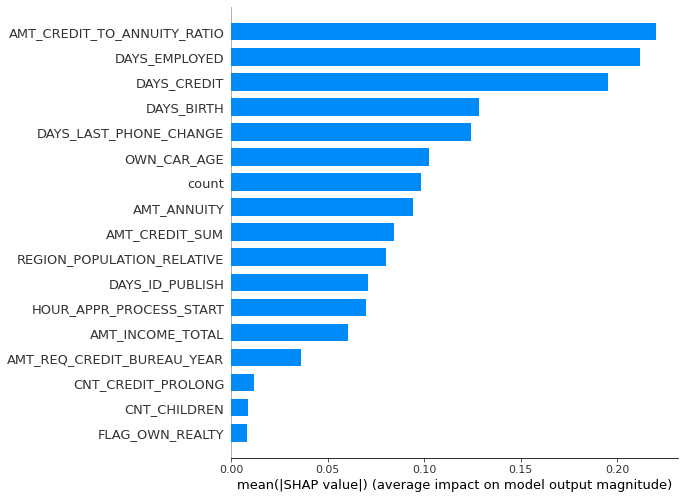

In [39]:
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

시각화 결과, 타겟값에 가장 큰 영향을 미치는 상위 5가지 변수는 아래와 같다.

- AMT_CREDIT_TO_ANNUITY_RATIO
- DAYS_EMPLOYED
- DAYS_CREDIT
- DAYS_BIRTH
- DAYS_LAST_PHONE_CHANGE


## 2.5 영향을 많이 주는 5개의 변수와 상환 여부와의 관계

※ 타겟값이 0이면 정상상환, 1이면 연체 혹은 문제가 있음

### 2.5.1. AMT_CREDIT_TO_ANNUITY_RATIO

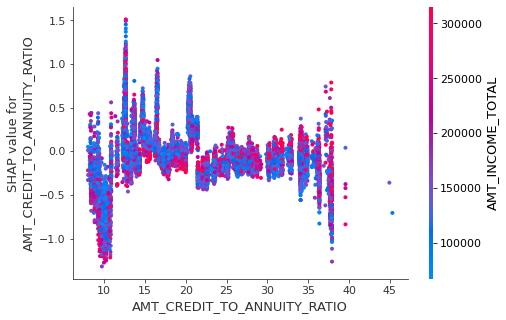

In [40]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO', shap_values, train[input_var])

AMT_CREDIT_TO_ANNUITY_RATIO 가 12~21 일 때는 대출금 상환을 잘 못한다.

### 2.5.2 DAYS_EMPLOYED
대출일 기준으로 며칠 전에 취업했는가 (ex. -10000은 대출 1만일 전에 취업을 함)

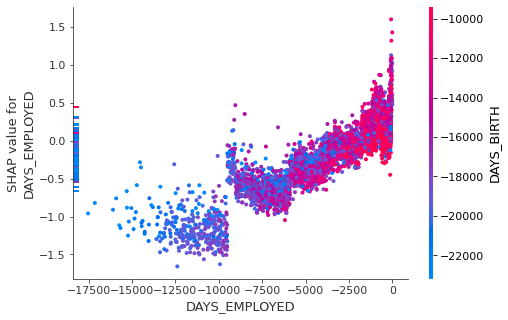

In [41]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values, train[input_var])

DAYS_EMPLOYED(취업한지)가 9000일 이상일 수록 대출상환 가능성이 높다.

### 2.5.3 DAYS_CREDIT
대출일 기준으로 며칠 전에 다른 대출을 받았는가

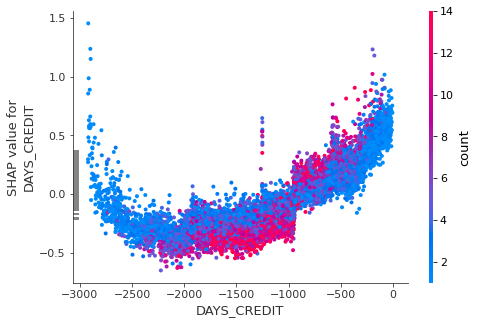

In [42]:
shap.dependence_plot('DAYS_CREDIT', shap_values, train[input_var])

DAYS_CREDIT 는 -3000일부터 -2000일까지는 대출 상환능력이 상승하지만, <br>
그 이후부터는 하락한다.

### 2.5.4 DAYS_BIRTH
대출일 기준으로 며칠 전에 태어났는가

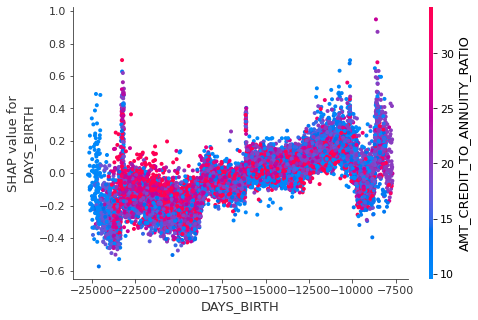

In [43]:
shap.dependence_plot('DAYS_BIRTH', shap_values, train[input_var])

나이가 많을 수록 대출상환 능력이 .

### 2.5.5 DAYS_LAST_PHONE_CHANGE
대출일 기준으로 며칠 전에 휴대전화를 바꿨는가

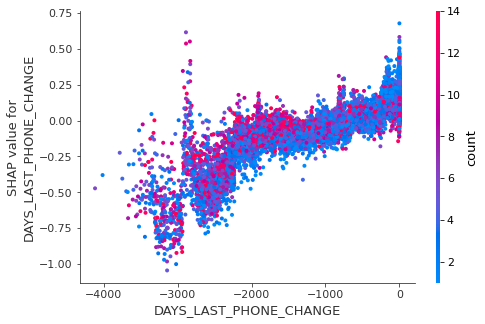

In [44]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values, train[input_var])

휴대전화를 바꾼지 오래 될 수록 대출금 상환 가능성이 크다.